# Factor model

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from edward.models import Normal, Uniform, StudentT
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

In [2]:
# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=1.0/(k+1)
        w[k+1,k]=-1.0/(k+1)
    w *= 3
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[0]=10
    shift[1]=23
    sigma = np.arange(D)+0.1
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma[d])+shift[d]
#     print("True principal axes:")
#     print(w)
#     print("Shift:")
#     print(shift)
    return x_train.astype(np.float32,copy=False), w, shift, sigma


#ed.set_seed(142)

N = 1000  # number of data points
D = 6  # data dimensionality
K = 3 # latent dimensionality

# DATA

x_train, w_true, shift, sigma_true = build_toy_dataset(N, D, K)

[[ 3.   0.   0. ]
 [-3.   1.5  0. ]
 [ 0.  -1.5  1. ]
 [ 0.   0.  -1. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]]


In [3]:
halfCauchy = StudentT(df=1., loc=0., scale=1.)

In [4]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    tmp = halfCauchy.sample(10000).eval()

In [5]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

In [6]:
import bijectors as bijector

In [7]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.])

In [8]:
sigma_true

array([ 0.1,  1.1,  2.1,  3.1,  4.1,  5.1])

## P-model

\begin{align}
i \in {1,...,D}\\
j \in {1,...,K}\\
n \in {1,...,N}\\
\tau &\sim StudentT(1,0)\\
\lambda_j &\sim StudentT(1,0)\\
w_{ij}&\sim N(0,|\tau||\lambda_j|)\\
z_{jn}&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [9]:
# P MODEL

K=D

sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))

#alpha = ed.models.Gamma(tf.ones([K])*0.002,tf.ones([K])*0.002)
lamda = StudentT(df=1., loc=tf.zeros([K]), scale=tf.ones([K]))
tau = StudentT(df=1., loc=0., scale=1.)
w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu = Normal(tf.zeros([D]),       tf.ones([D]))
x = ed.models.MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z)),mu), tf.reshape(tf.tile(sigma,[N]),[N,D]))

In [10]:
# Q MODEL
qtau = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([])),
                                                   tf.Variable(tf.random_normal([]))),
    bijector=bijector.Exp(),
    name="qtau")
qlamda = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([K])),
                                                   tf.Variable(tf.zeros([K]))),
    bijector=bijector.Exp(),
    name="qlamda")
# so far, only log-normals work
#qlamda = StudentT(df=1., loc=tf.Variable(tf.random_normal([K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
#qtau = StudentT(df=1., loc=tf.Variable(tf.random_normal([])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)

qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
                                  tf.Variable(tf.ones(D))),
    bijector=bijector.Exp(),
    name="qsigma")

#inference = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_high.T})
#inference.run(n_iter=4000, n_samples=20)

#print("Inferred principal axes (columns):")
#print(qw.mean().eval())
#print(qw.variance().eval())
#print("Inferred center:")
#print(qmu.mean().eval())
#print(qmu.variance().eval())

In [11]:
#inference3 = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train.T})
inference3 = ed.KLqp({lamda: qlamda, tau: qtau, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train.T})
inference3.initialize(n_iter=5000, n_print=1000, n_samples=50, optimizer='rmsprop')

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [12]:
learning_curve3 = []
for _ in range(inference3.n_iter):
    info_dict = inference3.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve3.append(info_dict['loss'])
plt.semilogy(learning_curve3)

{'loss': 2289769.8, 't': 1}
{'loss': 15776.062, 't': 1001}
{'loss': 15774.311, 't': 2001}
{'loss': 15771.404, 't': 3001}
{'loss': 15752.012, 't': 4001}


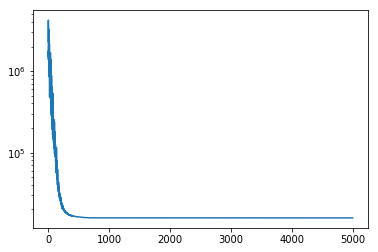

In [13]:
plt.show()

In [14]:
x_sim = ed.copy(x, {lamda: qlamda, tau: qtau, w: qw, z: qz, mu: qmu, sigma: qsigma})

In [15]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [16]:
pd.DataFrame(np.round(qw.mean().eval(),1))

,0,1,2,3,4,5
0,0.0,-2.8,0.0,0.6,0.0,-0.2
1,0.0,3.4,-0.0,0.5,0.0,-0.2
2,-0.0,-0.4,-0.0,-1.9,0.0,0.0
3,0.0,-0.1,0.0,0.6,0.0,1.9
4,-0.0,-0.1,-0.0,-0.3,0.0,-0.1
5,0.0,0.1,0.0,-0.2,-0.0,0.4


In [17]:
qw.mean()

<tf.Tensor 'Normal_4/mean_1/mul:0' shape=(6, 6) dtype=float32>

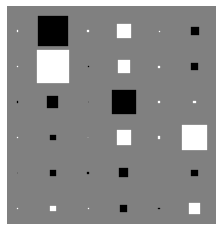

In [43]:
hinton(qw.mode().eval().T)
plt.show()

In [19]:
w_tmp = np.ones((D,D))*10**(-10)
w_tmp[:K,:3] = w_true

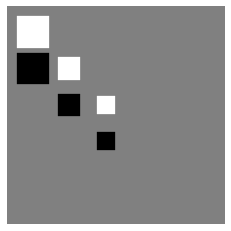

In [42]:
hinton(w_tmp.T)
plt.show()

In [21]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.])

In [22]:
qmu.mean().eval()

array([  1.01493444e+01,   2.28399353e+01,   3.41900624e-03,
        -1.47349074e-01,  -1.85023453e-02,   4.12698537e-01], dtype=float32)

In [23]:
sigma_true

array([ 0.1,  1.1,  2.1,  3.1,  4.1,  5.1])

In [24]:
qsigma.get_variables()[0].eval()

array([-0.01641837,  0.02711793,  0.6671226 ,  0.91862768,  1.41235209,
        1.54892135], dtype=float32)

In [25]:
foo = sorted(np.exp(qsigma.get_variables()[0].eval()))

In [26]:
foo

[0.98371565, 1.0274889, 1.9486222, 2.5058491, 4.1056008, 4.7063909]

In [27]:
tmp = qw.mean().eval()

In [28]:
tmp[abs(tmp)>0.05]

array([-2.84617138,  0.60490787, -0.20916325,  3.3839848 ,  0.48108509,
       -0.17037176, -0.39912775, -1.89789176, -0.0894078 ,  0.63444585,
        1.91678023, -0.13015965, -0.25703958, -0.13032776,  0.09826642,
       -0.16473882,  0.39344239], dtype=float32)

alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [30]:
qsigma.get_variables()[0].eval()

array([-0.01641837,  0.02711793,  0.6671226 ,  0.91862768,  1.41235209,
        1.54892135], dtype=float32)

In [31]:
x_train.shape

(6, 1000)

In [32]:
x_sim_sample = x_sim.sample().eval()

In [33]:
x_sim_sample

array([[  9.10963917,  22.05610275,   3.40863109,  -3.67845678,
         -0.41632515,   0.6024732 ],
       [  8.03965664,  24.91877174,  -1.31704938,  -0.54722989,
          1.63605857,  -0.06950793],
       [ 12.70218182,  18.54469109,   1.49105942,   1.28815389,
          1.64484954,   4.91708231],
       ..., 
       [ 15.3428545 ,  21.03070641,  -2.83235884,   1.29741538,
         -5.47068977,  -1.06050515],
       [  7.54545879,  24.5917511 ,   1.65372682,  -2.83945274,
         -1.40597832,   1.76864862],
       [  6.16737652,  28.24171257,  -4.25771523,   4.24217558,
         -1.39036381,   3.04113913]], dtype=float32)

In [34]:
x_true_and_sim = pd.DataFrame(np.c_[np.r_[x_train.T,x_sim_sample],np.r_[np.zeros(N),np.ones(N)]])

In [35]:
names = 'abcdefghijk'[:D+1]

In [36]:
x_true_and_sim.columns = [i for i in names]

In [37]:
sns.set()
scattermatrix = sns.pairplot(x_true_and_sim, hue=names[-1], diag_kind= 'kde', vars = [i for i in names[:-1]])#, plot_kws=dict(alpha=.2))

In [38]:
[ax.set_ylim(-40,40) for ax in scattermatrix.axes.flatten()]
[ax.set_xlim(-40,40) for ax in scattermatrix.axes.flatten()];
#[axes.set_xlim(-40,40) for axes in scattermatrix.axes]

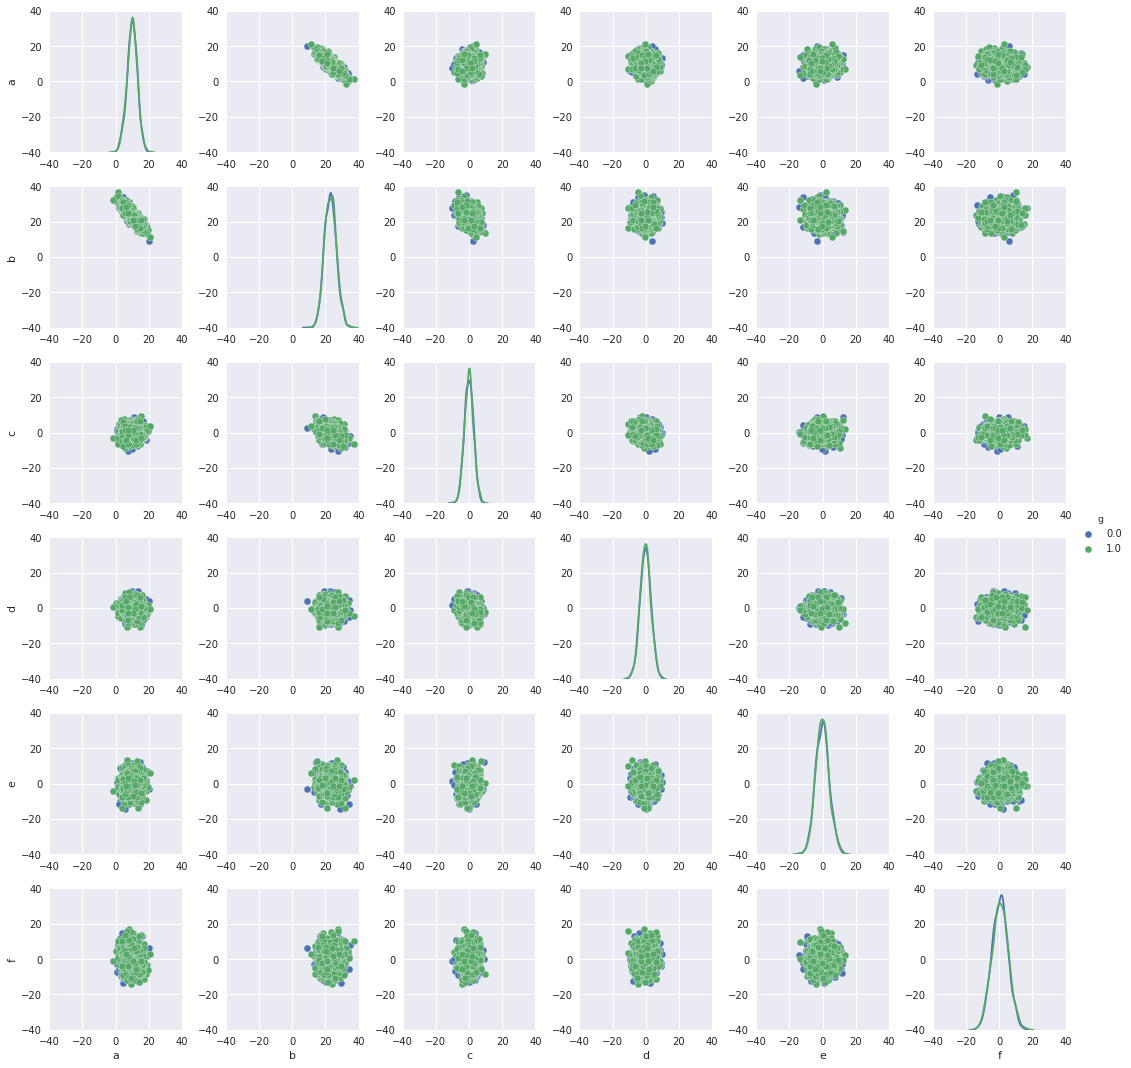

In [39]:
plt.show()

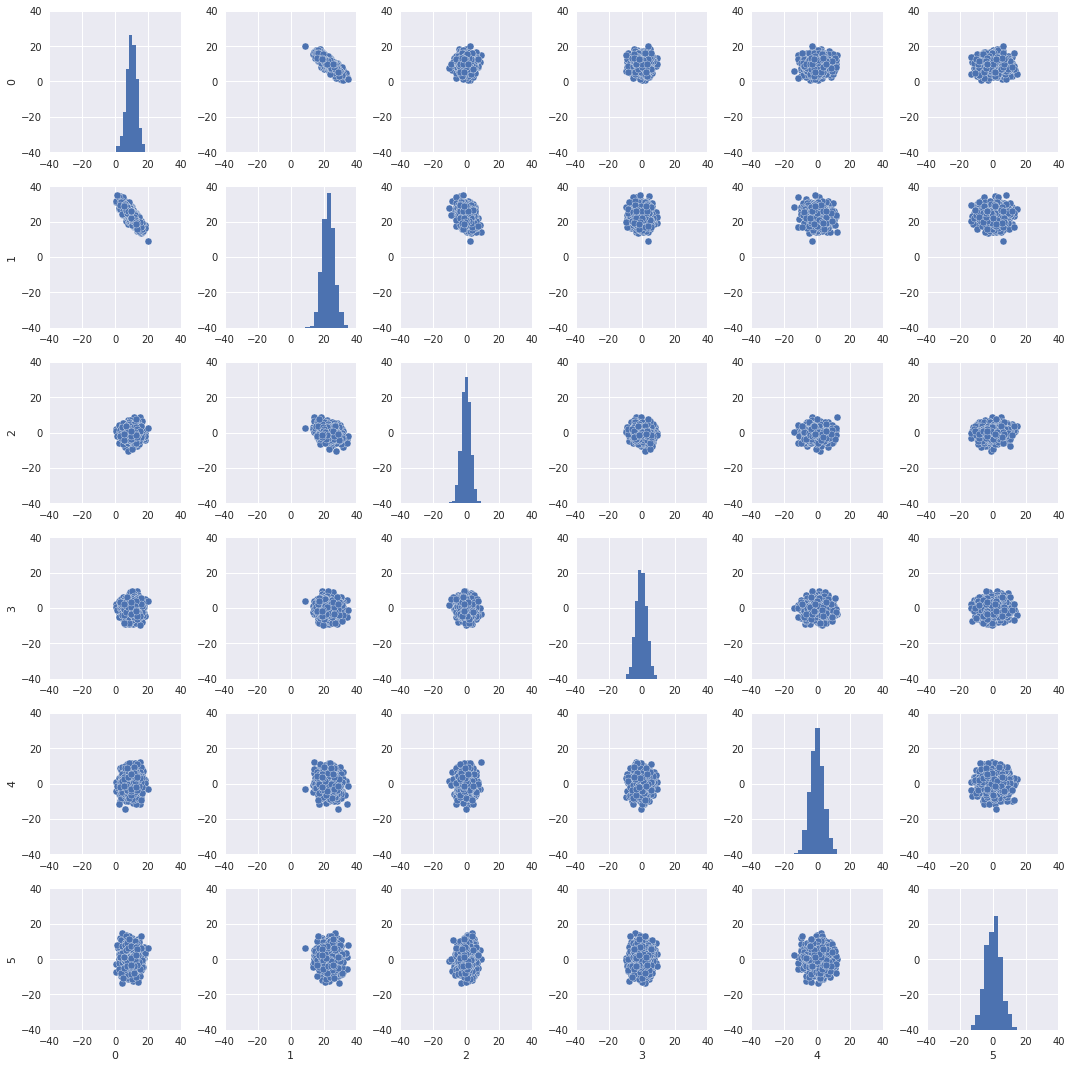

In [40]:
scattermatrix2 = sns.pairplot(pd.DataFrame(x_train.T))
[ax.set_ylim(-40,40) for ax in scattermatrix2.axes.flatten()]
[ax.set_xlim(-40,40) for ax in scattermatrix2.axes.flatten()];
plt.show()